In [329]:
import matplotlib.pyplot as plt
import scipy.stats as ss
import numpy as np
from pylab import *
from viewser.operations import fetch
from viewser import Queryset, Column
import glob

#some extra functions for some of the later demonstration
import pandas as pd
import numpy as np
import subprocess
#Define QuerySet
pd.set_option('display.max_rows', None)

In [330]:
queryset_base_PG = (Queryset("Benz_PG_CF", "priogrid_month")

    .with_column(Column("country_name", from_table = "country", from_column = "name")
        .transform.missing.replace_na()
        )
        
    .with_column(Column("year_id", from_table = "country_year", from_column = "year_id")
        )

    # target variable
    .with_column(Column("ged_sb", from_table = "ged2_pgm", from_column = "ged_sb_best_sum_nokgi")
        .transform.missing.replace_na()
        #.transform.ops.ln()
        )
        
    .with_column(Column("ged_ns", from_table = "ged2_pgm", from_column = "ged_ns_best_sum_nokgi")
        .transform.missing.replace_na()
        #.transform.ops.ln()
        )

    .with_column(Column("ged_os", from_table = "ged2_pgm", from_column = "ged_os_best_sum_nokgi")
        .transform.missing.replace_na()
        #.transform.ops.ln()
        )

    .with_column(Column("sb_count", from_table = "ged2_pgm", from_column = "ged_sb_best_count_nokgi")
        .transform.missing.replace_na()

        )

    .with_column(Column("ns_count", from_table = "ged2_pgm", from_column = "ged_ns_best_count_nokgi")
        .transform.missing.replace_na()

        )

    .with_column(Column("os_count", from_table = "ged2_pgm", from_column = "ged_os_best_count_nokgi")
        .transform.missing.replace_na()

        )
    .with_column(Column("pop_gpw_sum", from_table="priogrid_year", from_column="pop_gpw_sum")
        
        )
        )

In [331]:
queryset_base_CM = (Queryset("Benz_PG_CF", "country_month")

    .with_column(Column("country_name", from_table = "country", from_column = "name")
        .transform.missing.replace_na()
        )
        
    .with_column(Column("year_id", from_table = "country_year", from_column = "year_id")
        )

    # target variable
    .with_column(Column("ged_sb", from_table = "ged2_cm", from_column = "ged_sb_best_sum_nokgi")
        .transform.missing.replace_na()
        #.transform.ops.ln()
        )
        
    .with_column(Column("ged_ns", from_table = "ged2_cm", from_column = "ged_ns_best_sum_nokgi")
        .transform.missing.replace_na()
        #.transform.ops.ln()
        )

    .with_column(Column("ged_os", from_table = "ged2_cm", from_column = "ged_os_best_sum_nokgi")
        .transform.missing.replace_na()
        #.transform.ops.ln()
        )

    .with_column(Column("sb_count", from_table = "ged2_cm", from_column = "ged_sb_best_count_nokgi")
        .transform.missing.replace_na()

        )

    .with_column(Column("ns_count", from_table = "ged2_cm", from_column = "ged_ns_best_count_nokgi")
        .transform.missing.replace_na()

        )

    .with_column(Column("os_count", from_table = "ged2_cm", from_column = "ged_os_best_count_nokgi")
        .transform.missing.replace_na()

        )
    .with_column(Column("pop_gpw_sum", from_table="wdi_cy", from_column="wdi_sp_pop_totl")
        
        )
        )

In [332]:
#directories to set:

Change_to_your_local_drive = '/Users/gbenz/Documents/Food Security and Conflict/GIT'
Established_GIT_DIR = '/VIEWS_FAO_index/notebooks/Benz_experiments/Aggregation_Key_Tables/'

aggregation_tables_dir = Change_to_your_local_drive + Established_GIT_DIR

#GARRETT FIX THIS --
#less_than_expected.to_csv('/Users/gbenz/Documents/Common Data/inf_FPC.csv')
#Anamoly.to_csv(f'/Users/gbenz/Documents/Food Security and Conflict/{CM__or__PGstr}{res}Fatality_NoPop.csv')



#### This toolbox considers 3 primary paramters

**Parameter 1:** Is this analysis employing PGM or CM data?<br><br>
**Parameter 2:** What level of SPACE aggregation is the user interested in?<br>
*Options include -- Original PrioGRid aggregation 1x1 or courser aggregations 2x2, 3x3, 4x4, 5x5, 6x6, 8x8, 9x9, and 10x10*<br><br>
**Parameter 3:** What level of TIME aggregation is the user interested in?<br><br>
*Options include -- Original PrioGRid monthly resolution and annual*<br>
Note that within this time parameter, the range of available data is fixed between 1989-2022.<br><br>
**Parameter 4:** Define the processing extent to apply space and time factors<br><br>
**Parameter 5:** Establish what statistics to generate for the Unit of Analysis and designated Area of Responsibility'<br><br>

In [333]:
def PGM_preprocess(table):

    #replace NA Population values with 0
    table['pop_gpw_sum'] = table['pop_gpw_sum'].replace({np.nan:0})

    table['Fatalities_Sum'] = table['ged_sb'] + table['ged_ns'] + table['ged_os']
    table['PerCapitaFatalities'] = table['Fatalities_Sum'] / table['pop_gpw_sum']
    table['PerCapitaFatalities'] = table['PerCapitaFatalities'].replace({np.nan:0})

    table = table.drop(['ged_sb','ged_ns','ged_os','sb_count','ns_count','os_count'], axis = 1)

    return(table)


In [334]:
def report_infinity_values(base_table,CM__or__PG, resolution=0):

    if resolution == 0:
        res = '_'
    else:
        res = resolution

    CM__or__PGstr = CM__or__PG+'_'

    base_table['PerCapitaFatalities'] = base_table['PerCapitaFatalities'].replace([np.inf, -np.inf], np.nan)
    Anamoly = base_table[base_table['PerCapitaFatalities'].isna()]
    Anamoly.to_csv(f'/Users/gbenz/Documents/Food Security and Conflict/{CM__or__PGstr}{res}Fatality_NoPop.csv')
    base_table['PerCapitaFatalities'] = base_table['PerCapitaFatalities'].replace({np.nan:0})

    return(base_table)

In [422]:
def PRIO_Agg(table,time,CMorPG,scale=0,country=0):
    
    import glob

    CM_or_PG = CMorPG
    c = np.isinf(table['PerCapitaFatalities']).values.sum() 

    if c > 0:    
        table=report_infinity_values(table,CM_or_PG)

    if time == 'monthly':
        time_attribute = 'month_id'
    elif time == 'annual':
        time_attribute = 'year_id'

    if CM_or_PG == 'CM':
        if country == 0:
            table = table.rename(columns={'country_id':'Scale_ID'})
            table = table.rename(columns={'country_name':'Included_Countries'})
            table = table.drop(['year_id', 'pop_gpw_sum'], axis=1)
            return(table)
        elif country !=0:
            table = table.rename(columns={'country_id':'Scale_ID'})
            table = table.rename(columns={'country_name':'Included_Countries'})
            table = table.drop(['year_id', 'pop_gpw_sum'], axis=1)
            selected_country=table[table['Included_Countries'].isin([country])]
            return(selected_country)

    elif CM_or_PG == 'PG': 
        if scale == '1x1':
            table = table.rename(columns={'priogrid_gid':'Scale_ID'})
            table = table.drop(['year_id', 'pop_gpw_sum'], axis=1)
            table = table.rename(columns={'country_name':'Included_Countries'})
            if country == 0:
                return(table)
            else:
                selected_country=table[table['Included_Countries'].isin([country])]
                return(selected_country)    
        #--------------------------------------------------
        else:
            source_PG_aggregation_dir = '/Users/gbenz/Documents/Common Data/PG Aggregation/'
            allFiles = glob.glob(source_PG_aggregation_dir + "/*.csv")

            for filename in allFiles:
                    if scale in filename:
                        #print(filename)
                        break
            Aggregation_file = filename

            single_res = int(scale.split('x')[0])

            Expected = single_res ** 2

            pg_AG = pd.read_csv(Aggregation_file)

            pg_AG['gid'] = pg_AG['gid'].astype(str)
            pg_AG['Id'] = pg_AG['Id'].astype(str)

            pg_AG['Scale_ID'] = pg_AG.groupby(['Id'])['gid'].transform(lambda x : '_'.join(x))

            pg_AG['gid'] = pg_AG['gid'].astype('int64')
            pg_AG['Id'] = pg_AG['Id'].astype('int64')
        #A method to get rows that communicate 1. Each indivdiual geospatial abstract id and corresponding PRIOgrid ID 
            pg_AG__FOR_VALIDATE = pg_AG.groupby(['Id','Scale_ID']).size().to_frame().iloc[:, :-1].reset_index()
            pg_AG__FOR_VALIDATE = pg_AG__FOR_VALIDATE.sort_values(by='Scale_ID')

            pg__AG = pg_AG.groupby('Scale_ID')['gid'].apply(list)
            pg__AG__dic = pg__AG.to_dict()

            table['Scale_ID'] = table.priogrid_gid.map({item: k for k, v in pg__AG__dic.items() for item in v})
            df_2022 = table.sort_values(by=['Scale_ID','priogrid_gid'], ascending=[False,True])

        #changes here --
            withcountry = df_2022.groupby(['Scale_ID','country_name']).size().to_frame().iloc[:, :-1].reset_index()
            withcountry['Country_present'] = withcountry.groupby(['Scale_ID'])['country_name'].transform(lambda x : '___'.join(x))
            withcountry = withcountry.drop(['country_name'], axis=1).drop_duplicates()
            withcountry__dic = dict(zip(withcountry.Scale_ID, withcountry.Country_present))
        #---------
            check = df_2022.groupby(['priogrid_gid','Scale_ID']).size().to_frame().iloc[:, :-1].reset_index()
            check = check.sort_values(by='Scale_ID')

            check_PGID = check.groupby(['Scale_ID']).size().to_frame().reset_index()
            check_PGID = check_PGID.rename(columns = {0:'Size'})
            check_PGID = check_PGID.sort_values(by='Size')
            less_than_expected = check_PGID[check_PGID['Size'] < Expected]
            #print(less_than_expected)
            less_than_expected.to_csv('/Users/gbenz/Documents/Common Data/inf_FPC.csv')

            df_2022_grouped = df_2022.groupby([time_attribute,'Scale_ID']).agg({'PerCapitaFatalities':'sum','Fatalities_Sum':'sum'}).reset_index()

            if country == 0:
                return(df_2022_grouped)
            else:
                df_2022_grouped['Countries_In_AG_Unit']= df_2022_grouped['Scale_ID'].map(withcountry__dic)
                df_2022_grouped['Included_Countries'] = df_2022_grouped['Countries_In_AG_Unit'].str.split('___')
                selected_country = df_2022_grouped.loc[df_2022_grouped['Included_Countries'].explode().eq(country).loc[lambda x: x].index]
                selected_country = selected_country.drop('Included_Countries', axis=1)
                return(selected_country)

In [335]:
def PRIO_Aggregation(table,time,CMorPG,scale=0,country=0):
    
    import glob

    CM_or_PG = CMorPG
    c = np.isinf(table['PerCapitaFatalities']).values.sum() 

    if c > 0:    
        table=report_infinity_values(table,CM_or_PG)

    if time == 'monthly':
        time_attribute = 'month_id'
    elif time == 'annual':
        time_attribute = 'year_id'

    if scale == '1x1':
        table = table.rename(columns={'priogrid_gid':'Scale_ID'})
        table = table.drop(['year_id', 'pop_gpw_sum'], axis=1)
        table = table.rename(columns={'country_name':'Included_Countries'})
        if country == 0:
            return(table)
        else:
            selected_country=table[table['Included_Countries'].isin([country])]
            return(selected_country)
        
    elif scale == 0:
        table = table.rename(columns={'country_id':'Scale_ID'})
        table = table.drop(['year_id', 'pop_gpw_sum'], axis=1)
        return(table) 
    #--------------------------------------------------
    else:
        source_PG_aggregation_dir = '/Users/gbenz/Documents/Common Data/PG Aggregation/'
        allFiles = glob.glob(source_PG_aggregation_dir + "/*.csv")

        for filename in allFiles:
                if scale in filename:
                    #print(filename)
                    break
        Aggregation_file = filename

        single_res = int(scale.split('x')[0])

        Expected = single_res ** 2

        pg_AG = pd.read_csv(Aggregation_file)

        pg_AG['gid'] = pg_AG['gid'].astype(str)
        pg_AG['Id'] = pg_AG['Id'].astype(str)

        pg_AG['Scale_ID'] = pg_AG.groupby(['Id'])['gid'].transform(lambda x : '_'.join(x))

        pg_AG['gid'] = pg_AG['gid'].astype('int64')
        pg_AG['Id'] = pg_AG['Id'].astype('int64')
    #A method to get rows that communicate 1. Each indivdiual geospatial abstract id and corresponding PRIOgrid ID 
        pg_AG__FOR_VALIDATE = pg_AG.groupby(['Id','Scale_ID']).size().to_frame().iloc[:, :-1].reset_index()
        pg_AG__FOR_VALIDATE = pg_AG__FOR_VALIDATE.sort_values(by='Scale_ID')

        pg__AG = pg_AG.groupby('Scale_ID')['gid'].apply(list)
        pg__AG__dic = pg__AG.to_dict()

        table['Scale_ID'] = table.priogrid_gid.map({item: k for k, v in pg__AG__dic.items() for item in v})
        df_2022 = table.sort_values(by=['Scale_ID','priogrid_gid'], ascending=[False,True])

    #changes here --
        withcountry = df_2022.groupby(['Scale_ID','country_name']).size().to_frame().iloc[:, :-1].reset_index()
        withcountry['Country_present'] = withcountry.groupby(['Scale_ID'])['country_name'].transform(lambda x : '___'.join(x))
        withcountry = withcountry.drop(['country_name'], axis=1).drop_duplicates()
        withcountry__dic = dict(zip(withcountry.Scale_ID, withcountry.Country_present))
    #---------
        check = df_2022.groupby(['priogrid_gid','Scale_ID']).size().to_frame().iloc[:, :-1].reset_index()
        check = check.sort_values(by='Scale_ID')

        check_PGID = check.groupby(['Scale_ID']).size().to_frame().reset_index()
        check_PGID = check_PGID.rename(columns = {0:'Size'})
        check_PGID = check_PGID.sort_values(by='Size')
        less_than_expected = check_PGID[check_PGID['Size'] < Expected]
        #print(less_than_expected)
        less_than_expected.to_csv('/Users/gbenz/Documents/Common Data/inf_FPC.csv')

        df_2022_grouped = df_2022.groupby([time_attribute,'Scale_ID']).agg({'PerCapitaFatalities':'sum','Fatalities_Sum':'sum'}).reset_index()

        if country == 0:
            return(df_2022_grouped)
        else:
            df_2022_grouped['Countries_In_AG_Unit']= df_2022_grouped['Scale_ID'].map(withcountry__dic)
            df_2022_grouped['Included_Countries'] = df_2022_grouped['Countries_In_AG_Unit'].str.split('___')
            selected_country = df_2022_grouped.loc[df_2022_grouped['Included_Countries'].explode().eq(country).loc[lambda x: x].index]
            selected_country = selected_country.drop('Included_Countries', axis=1)
            return(selected_country)

In [336]:
#def report_length(data):

    #if scale == 'Individual':
    #    s = 'This individual'
    #elif scale == 'Global':
    #    s = ' The global'

    #if resolution == 0:
    #    res = ''
    #else:
    #    res = 'and ' + resolution + ' resolution'

    #if time == 'monthly':
    #    t = 'month_id'
    #elif time == 'annual':
    #    t = 'year_id'

    #events_df_2022 = len(data)
    #return(events_df_2022)
    #PG_totalcells = len(pd.unique(data['Scale_ID']))
    #PG_totalmonths = len(pd.unique(data[t])) 
    #return(f'{s} {PG_or_CM} level {res} contains {events_df_2022} events.\nThis is calculated from {PG_totalcells} * {PG_totalmonths}')

In [337]:
#p = np.array(arange(70, 100.1, 0.1))
#divisor = 100
#p_div = p/divisor
#l = p_div.tolist()
#l_3dec = [ round(elem, 3) for elem in l ]

#percentile = [.5,.7,.8,.81,.82,.83,.84,.85,.86,.87,.88,.89,.9,.95,.98,.99,.991,.992,.993,.994,.995,.996,.997,.998,.999,1]
#print(l_3dec)

In [445]:
def Format_summary_stats(PG_or_CM, table_to_describe,field_to_describe,zero__or__non_zero):
    
    if PG_or_CM == 'PG':
        lowpercentile = 40
    else:
        lowpercentile = 0

    p = np.array(arange(lowpercentile, 100.1, 0.1))
    divisor = 100
    p_div = p/divisor
    l = p_div.tolist()
    l_3dec = [round(elem, 3) for elem in l ]

    if field_to_describe == 'Fatalities_Sum':
        SummaryField = 'Fatalities'

    elif field_to_describe == 'PerCapitaFatalities':
        SummaryField = 'Fatalities Per Capita'

    if zero__or__non_zero == 'zero' and PG_or_CM == 'PG':
        #percentile = [.5,.7,.8,.85,.9,.95,.98,.99,.991,.992,.993,.994,.995,.996,.997,.998,.999,1]
        data = pd.DataFrame({SummaryField: table_to_describe[field_to_describe].describe(percentiles=l_3dec)})

    elif zero__or__non_zero == 'zero' and PG_or_CM == 'CM':
        #percentile = [.5,.7,.8,.81,.82,.83,.84,.85,.86,.87,.88,.89,.9,.95,.98,.99,.991,.992,.993,.994,.995,.996,.997,.998,.999,1]
        data = pd.DataFrame({SummaryField: table_to_describe[field_to_describe].describe(percentiles=l_3dec)})

    elif zero__or__non_zero == 'non-zero':
        attribute_nozero=table_to_describe[table_to_describe[field_to_describe]!= 0]
        length_of_attribute_nozero = len(attribute_nozero)
        percentile = [0,.25,.5,.75,.8,.85,.9,.95,.99,.995,1]
        data = pd.DataFrame({SummaryField: attribute_nozero[field_to_describe].describe(percentiles=percentile)})

    #data = pd.DataFrame({SummaryField: table_to_describe[field_to_describe].describe(percentiles=percentile)})
    data = data.reset_index()
    data = data.rename(columns={'index':'Percentile'})
    data = data.iloc[4:][:-1]
    data['Percentile'] = data['Percentile'].str[:-1]

    if field_to_describe == 'Fatalities_Sum' and zero__or__non_zero == 'non-zero':
        data['Fatalities'] = (data['Fatalities']).astype(int)
        #attribute_nozero=table_to_describe[table_to_describe['Fatalities_Sum']!= 0]
        return(attribute_nozero, data, length_of_attribute_nozero)

    elif field_to_describe == 'Fatalities_Sum' and zero__or__non_zero == 'zero':
        data['Fatalities'] = (data['Fatalities']).astype(int)
        return(data)

    elif field_to_describe == 'PerCapitaFatalities' and zero__or__non_zero == 'non-zero':
        #attribute_nozero=table_to_describe[table_to_describe['PerCapitaFatalities']!= 0]
        return(attribute_nozero, data, length_of_attribute_nozero)

In [339]:
def represent_zero_percentiles(insert_percentile):
    float_percentile_at_1 = float(insert_percentile)
    if float_percentile_at_1 >= 99.5:
        sub_perc = [99.7, 99.8, 99.9, 100]
        sub_perc.insert(0, float_percentile_at_1)
        return(sub_perc)

    elif float_percentile_at_1 < 99.5 and float_percentile_at_1 >= 99:
        sub_perc = [99.5, 99.7, 99.9, 100]
        sub_perc.insert(0, float_percentile_at_1)
        return(sub_perc)

    elif float_percentile_at_1 < 99 and float_percentile_at_1 >= 98:
        sub_perc = [99, 99.5, 100]
        sub_perc.insert(0, float_percentile_at_1)
        return(sub_perc)

    elif float_percentile_at_1 < 98 and float_percentile_at_1 >= 95:
        sub_perc = [99, 99.5, 100]
        sub_perc.insert(0, float_percentile_at_1)
        return(sub_perc)

    elif float_percentile_at_1 < 95 and float_percentile_at_1 >= 90:
        sub_perc = [95, 99, 99.5, 100]
        sub_perc.insert(0, float_percentile_at_1)
        return(sub_perc)

    elif float_percentile_at_1 < 90 and float_percentile_at_1 >= 85:
        sub_perc = [90, 95, 99, 100]
        sub_perc.insert(0, float_percentile_at_1)
        return(sub_perc)

    elif float_percentile_at_1 < 85 and float_percentile_at_1 >= 80:
        sub_perc = [85, 90, 95, 99, 100]
        sub_perc.insert(0, float_percentile_at_1)
        return(sub_perc)

    elif float_percentile_at_1 < 80 and float_percentile_at_1 >= 70:
        sub_perc = [80, 85, 90, 95, 99, 100]
        sub_perc.insert(0, float_percentile_at_1)
        return(sub_perc)
    
    elif float_percentile_at_1 < 70 and float_percentile_at_1 >= 50:
        sub_perc = [70, 80, 85, 90, 95, 99, 100]
        sub_perc.insert(0, float_percentile_at_1)
        return(sub_perc)
    
    elif float_percentile_at_1 <50:
        sub_perc = [50, 75, 80, 85, 90, 95, 99, 100]
        sub_perc.insert(0, float_percentile_at_1)
        return(sub_perc)

In [340]:
def correct_definition_df(definition_dataframe,original_dataframe,zero__or__nonzero,single_cell_analysis,PG__or__CM='PG',single_cell_analysis_percentiles=[99,95]):

    check_list = list(definition_dataframe)

    if 'Fatalities' in check_list:
        #attribute_nozero=original_dataframe[original_dataframe['Fatalities_Sum']!= 0]
        #return(Fatalities_nozero)

        if zero__or__nonzero == 'zero':
            percentile_at_1 = list(definition_dataframe.loc[definition_dataframe['Fatalities'] == 1, 'Percentile'])[0]
            sub_perc=represent_zero_percentiles(percentile_at_1)

            search_P = list(map(str, sub_perc))
            #print(search_P)
            definition_dataframe['Percentile'] = definition_dataframe['Percentile'].astype('string')
            from_sub_perc = definition_dataframe[definition_dataframe['Percentile'].isin(search_P)]
            #sub_perc = ['84','90','95','99','99.5','100']
            #definition_dataframe['Percentile'] = definition_dataframe['Percentile'].astype('string')
            #from_sub_perc = definition_dataframe[definition_dataframe['Percentile'].isin(sub_perc)]
            #from_sub_perc = definition_dataframe[definition_dataframe['Percentile'] in sub_perc]
            #match_p = definition_dataframe.loc[definition_dataframe['Percentile'] == i]
            def_values = from_sub_perc['Fatalities'].unique()
            #print(def_values)
        else:
            def_values = definition_dataframe['Fatalities'].unique()
        id_fatality = []
        id_triggers = []
        id_p = []
            
    if 'Fatalities Per Capita' in check_list:
        def_values = definition_dataframe['Fatalities Per Capita'].unique()
        id_percapita = []
        id_triggers = []
        id_p = []

    collected = pd.DataFrame()

    if single_cell_analysis == 'Yes':
        def_values = single_cell_analysis_percentiles

    for i in def_values:
                            if 'Fatalities' in check_list and i == 0.0:
                                #if i == 0.0:
                                continue
                            elif 'Fatalities' in check_list and i != 0.0:
                                match_p = definition_dataframe.loc[definition_dataframe['Fatalities'] == i]
                                perc = match_p.at[match_p.index[0], 'Percentile']
                                limit = original_dataframe.loc[original_dataframe['Fatalities_Sum'] >= i]
                                triggers = len(limit.index)
                                fatality = i

                                id_p.append(perc)
                                id_fatality.append(fatality)
                                id_triggers.append(triggers)

                                Out_Percentile = pd.DataFrame(list(zip(id_p, id_fatality, id_triggers)),
                                    columns=['Percentile','Fatalities','Occurance'])
                                
                            if 'Fatalities Per Capita' in check_list:
                                match_p = definition_dataframe.loc[definition_dataframe['Fatalities Per Capita'] == i]
                                perc = match_p.at[match_p.index[0], 'Percentile']
                                limit = original_dataframe.loc[original_dataframe['PerCapitaFatalities'] >= i]
                                triggers = len(limit.index)
                                capita = i                        

                                id_p.append(perc)
                                id_percapita.append(capita)
                                id_triggers.append(triggers)

                                Out_Percentile = pd.DataFrame(list(zip(id_p, id_percapita, id_triggers)),
                                    columns=['Percentile','Fatalities Per Capita','Occurance'])
                            
    if zero__or__nonzero == 'zero' or single_cell_analysis == 'Yes':
           
        collected = pd.concat([collected, Out_Percentile], ignore_index=True) 
        return(collected)
    
    elif zero__or__nonzero == 'non-zero'and 'Fatalities Per Capita' in check_list:
        collected = pd.concat([collected, Out_Percentile], ignore_index=True) 
        collected['Fatalities Per Capita'] = collected['Fatalities Per Capita']*10000
        collected['Fatalities Per Capita'] = collected['Fatalities Per Capita'].round(1)
        collected = collected.rename(columns={'Fatalities Per Capita':'Per Capita'})
        Transpose_desc=collected.transpose()
        new_header = Transpose_desc.iloc[0] #grab the first row for the header
        Transpose_desc_less = Transpose_desc[1:] #take the data less the header row
        Transpose_desc_less.columns = new_header
        Transpose_desc_less = Transpose_desc_less.reset_index()
        Transpose_desc_less = Transpose_desc_less.rename(columns={'index':'Percentile'})

        return(Transpose_desc_less)

    elif zero__or__nonzero == 'non-zero' and 'Fatalities' in check_list:
        collected = pd.concat([collected, Out_Percentile], ignore_index=True) 
        Transpose_desc=collected.transpose()
        new_header = Transpose_desc.iloc[0] #grab the first row for the header
        Transpose_desc_less = Transpose_desc[1:] #take the data less the header row
        Transpose_desc_less.columns = new_header
        Transpose_desc_less = Transpose_desc_less.reset_index()
        Transpose_desc_less = Transpose_desc_less.rename(columns={'index':'Percentile'})

        return(Transpose_desc_less)

    #elif zero__or__nonzero != 'zero' or zero__or__nonzero != 'non-zero':
        #print('This parameter was incorrectly named. Select from zero or non-zero') 

In [341]:
def params_for_graphs(description,original_df,a,b,c,):

    a=str(a)
    b=str(b)
    c=str(c)

    desc_attribute = description.at[0, 'Percentile']
    if desc_attribute == 'Fatalities':
        attribute = 'Fatalities_Sum'
    elif desc_attribute == 'Fatalities Per Capita':
        attribute = 'PerCapitaFatalities'

    f_fpc=original_df[attribute]
    #fpc=df_109_516___Fatalities['PerCapitaFatalities']

    #print('trying to now select 85th percentile value')
    Select_a_Percentile = description.at[0,a]
    Select_b_Percentile = description.at[0,b]
    Select_c_Percentile = description.at[0,c]

#print(Select_95_Percentile)

#print()
    Fatalities_a = f_fpc[f_fpc <= Select_a_Percentile]
    Fatalities_a_b = f_fpc[(f_fpc > Select_a_Percentile) & (f_fpc <= Select_b_Percentile)]
    Fatalities_b_c = f_fpc[(f_fpc > Select_b_Percentile) & (f_fpc <= Select_c_Percentile)]
    Fatalities_c = f_fpc[(f_fpc > Select_c_Percentile)]

    Fatalities_a = np.sort(Fatalities_a)
    cdf_a = 1.0 * np.arange(len(Fatalities_a)) / float(len(Fatalities_a) - 1)
    Fatalities_a_b = np.sort(Fatalities_a_b)
    cdf_a_b = 1.0 * np.arange(len(Fatalities_a_b)) / float(len(Fatalities_a_b) - 1)
    Fatalities_b_c = np.sort(Fatalities_b_c)
    cdf_b_c = 1.0 * np.arange(len(Fatalities_b_c)) / float(len(Fatalities_b_c) - 1)
    Fatalities_c = np.sort(Fatalities_c)
    cdf_c = 1.0 * np.arange(len(Fatalities_c)) / float(len(Fatalities_c) - 1)
    return((Fatalities_a,cdf_a), (Fatalities_a_b,cdf_a_b), (Fatalities_b_c,cdf_b_c), (Fatalities_c,cdf_c))

In [342]:
from collections import Counter

def single_hist_params (hist):
    xlim_max = max(hist)
    xlim_min = min(hist-1) # for x limit min

    x_ticks = linspace(xlim_min,xlim_max,5)
    x_int_list = [int(item) for item in x_ticks]

    x_tick_labels = [str(item) for item in x_int_list]
    x_tick_labels[1] = ''
    x_tick_labels[3] = ''

    num_most_common = Counter(hist).most_common(1)[0][1]
    ylim_max=num_most_common + 3 #for y limit max

    ylim_min = 0

    y_ticks = linspace(ylim_min,ylim_max,3)
    y_int_list = [int(item) for item in y_ticks]

    y_tick_labels = [str(item) for item in y_int_list]
    return(xlim_max, xlim_min, x_int_list, x_tick_labels, ylim_max, ylim_min, y_int_list, y_tick_labels)

In [432]:
def summarytextline (cm_or_pg, total_events, perc_nonzero, total_nonzero, fpc_99th_nz, fpc_99th_nz_occurance, month_or_annual='monthly', resolution=0, country=0):

    if cm_or_pg == 'PG' and country != 0:
        text = f'In {country}, employing a unit of analysis that considers a {resolution} priogrid at a {month_or_annual} temporal resolution, yields {total_events} total events.\nFrom this value, just less than {perc_nonzero}% report zero fatalities. Among a subset data frame, consisting of {total_nonzero} non-zero events,\nthe 99th percentile reports {fpc_99th_nz} fatalities per capita (per 10,000 individuals), a threshold experienced {fpc_99th_nz_occurance} times.'
        return(text)
    
    if cm_or_pg == 'PG' and country == 0:
        text = f'Across Africa and the Middle East, employing a unit of analysis that considers a {resolution} priogrid at a {month_or_annual} temporal resolution,\nyields {total_events} total events. From this value, just less than {perc_nonzero}% report zero fatalities. Among a subset data frame,\nconsisting of {total_nonzero} non-zero events, the 99th percentile reports {fpc_99th_nz} fatalities per capita (per 10,000 individuals), a threshold experienced {fpc_99th_nz_occurance} times.'
        return(text)

    if cm_or_pg == 'CM' and country == 0:
        text = f'Globally, employing a unit of analysis that considers each county boundary at a {month_or_annual} temporal resolution,\nyields {total_events} total events. From this value, just less than {perc_nonzero}% report zero fatalities. Among a subset data frame,\nconsisting of {total_nonzero} non-zero events, the 99th percentile reports {fpc_99th_nz} fatalities per capita (per 10,000 individuals), a threshold experienced {fpc_99th_nz_occurance} times.'
        return(text)

    if cm_or_pg and country != 0:
        text = f'In {country}, employing a unit of analysis that exclusively considers this county boundary at a {month_or_annual} temporal resolution,\nyields {total_events} total events. From this value, just less than {perc_nonzero}% report zero fatalities. Among a subset data frame, consisting\nof {total_nonzero} non-zero events, the 99th percentile reports {fpc_99th_nz} fatalities per capita (per 10,000 individuals),\na threshold experienced {fpc_99th_nz_occurance} times.'
        return(text)


In [344]:
def format_for_summarytextline(cm_or_pg,A,B,C,D,month_or_annual='monthly',resolution=0, country=0):

    cm__or__pg = cm_or_pg
    mora = month_or_annual
    r = resolution
    c = country

    total_events = len(A)
    Percentage_non_zero = B.loc[0, 'Percentile']
    total_nonzero = C.loc[1, '0']
    PCF_Occurance = D.loc[1, '99']
    PCF_total = D.loc[0, '99']
        
    txt = summarytextline(cm__or__pg, total_events, Percentage_non_zero, total_nonzero, PCF_total, PCF_Occurance, mora, r, c)
    return(txt)

In [388]:
def annotate_axes(ax, text, fontsize=18):
        ax.text(0.5, 0.5, text, transform=ax.transAxes,
                ha="center", va="center", fontsize=fontsize, color="darkgrey")

    #def statsheet(zerotable, nonzerotable_Fatality, nonzerotable_fpc, hist1, cdf1, hist2, cdf2, hist3, cdf3, hist4, cdf4, timeseries):    
def statsheet(zerotable, textsummary, nonzerotable_Fatality, nonzerotable_fpc, hist1, cdf1, hist2, cdf2, hist3, cdf3, hist4, cdf4, timeline, PG_or_CM, month_or_annual, country=0, resolution=0):    

    #nonzerotable_fpc['Fatalities Per Capita'] = nonzerotable_fpc['Fatalities Per Capita']*10000
    #nonzerotable_fpc['Fatalities Per Capita'] = nonzerotable_fpc['Fatalities Per Capita'].round(1)
    Unit_of_analysis = PG_or_CM
    mora = month_or_annual 
    r = resolution
    c = country
    if resolution != 0:
        res = resolution
    else:
        res = ''

    if country != 0:
        cntry = country
    else:
         cntry = 'Global'
    
    Title = cntry +' ' + mora + ' ' + res + ' ' + Unit_of_analysis + ' ' + 'Stat Sheet'

    #if resolution != 0:

    #For timeline--------------------------v
    timeline_month_fatalitytotal = timeline.groupby(["month_id"]).Fatalities_Sum.sum().reset_index().reset_index()

    timeline_month_fatalities20000 = timeline_month_fatalitytotal.loc[timeline_month_fatalitytotal['Fatalities_Sum']>20000]

    index_to_color = timeline_month_fatalities20000['index']
    #--------------------------------------^

    units_of_analysis = '13000'
    percent_zero_fromtable = '99.3%'
    percent_nonzero_fromtable ='.6%'
    total_nonzero_fromtable = '1300'
    inf_total = '7'
    MissingData1 ='Y# occurances of 2 or less# fatalities and Y# occurances of 3-5 fatalities.'
    MissingData2 = 'Y# counts of fatalities between n and n'
    MissingData3 = 'XXXXXXX# fatalities were recorded between XX and XX of XXXX, XXXXXX in XX-XX, XXXXXXXX# in XX-XX, and XXXXX# in XX-XX'
    #inputtext = 'In this text I want to summarize:\nalso, the per capita row reflects 1/10,000 individuals 1. The definition of event in this iteration 2.The total number of Events.\n Including how many months and the month ranges. Describe the graphs \n why do the total fatalities not match the total PCF (becuse 7 events in area with no population\n This is the last line that you have room for!'
    #inputtext = f'Defining an event, summarizing fatalities, as a 1x1 standard PRIO Grid across a monthly temporal resolution produced {units_of_analysis} units of analysis. Summary tables\n discriminate between events reflecting zero and non-zero fatality results. At the employed unit scale, zero fatalities account for {percent_zero_fromtable} of all events. The remaining\n tables and graphics are constituent to that remaining {percent_nonzero_fromtable} ({total_nonzero_fromtable}) fatalities. Non-zero results from the Per Capita table reflect a unique total from the reported fatalities,\n {inf_total} events contained fatalities in units with no expected population values. Several graphics host data that is not completely visualized with extreme values exceeding\n the Y-axis; These locations are indicated by a prominent red bar. The following relationships uncover the obscured information. 1st-85th Percentile: There were\n {MissingData1} ; 99.5-100th Percentile: {MissingData2}'
    inputtext = 'This is incomplete for now but statistics are generated to insert in next push...'
    fig = plt.figure(figsize=(11, 8.5), constrained_layout = True)
    spec = fig.add_gridspec(7, 4)

#Zero table
    ax0 = fig.add_subplot(spec[0:3, :-3])
    #annotate_axes(ax0, 'ax0')
    table_ax0 = ax0.table(cellText=zerotable.values,
                    colLabels=zerotable.columns,
                    loc='center',
                    cellLoc='center',
                    rowLoc='center')
    
    FirstFatality = table_ax0[1,0]
    FirstFatality.set_edgecolor('#e34a33')
    FirstFatality.set_linewidth(2)

    ax0.add_patch(FirstFatality)
    
    table_ax0.set_fontsize(8)
    ax0.axis('off')
    table_ax0.scale(1, 1.65)
    ax0.set_title('Distribution of Fatalities\nAll zero and non-zero events', size=10)

# Summary Text
    
    #summarytext = summarytextline (Unit_of_analysis, total_events, perc_nonzero, total_nonzero, fpc_99th_nz, fpc_99th_nz_occurance, mora, r, c)

    ax1 = fig.add_subplot(spec[0, -3:])
    #annotate_axes(ax1, 'ax1')
    ax1.text(0, 0.5,textsummary, fontsize=8, va='top',wrap='True',
                      bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))
    ax1.axis('off')
    ax1.set_title(Title, size=14, fontweight="bold")

    #ax1.margins(x=-.25)
    #text_ax1.scale(-.25, 1)

#plt.text(5, 5, input_text, fontsize=10, style='oblique', ha='center', va='top', wrap=True, rotation=-30)

#Non-Zero Fatalities
    ax2 = fig.add_subplot(spec[1, -3:])
    #annotate_axes(ax1, 'ax1')
    table_ax2 = ax2.table(cellText=nonzerotable_fpc.values,
                    colLabels=nonzerotable_fpc.columns,
                    loc='center',
                    cellLoc='center',
                    rowLoc='center')
    
    FPC_99_val = table_ax2[1,9]
    FPC_99_val.set_edgecolor('#e34a33')
    FPC_99_val.set_linewidth(2.5)

    FPC_99_occ = table_ax2[2,9]
    FPC_99_occ.set_edgecolor('#e34a33')
    FPC_99_occ.set_linewidth(2.5)

    ax2.add_patch(FPC_99_val)
    ax2.add_patch(FPC_99_occ)

    table_ax2.auto_set_font_size(False)
    table_ax2.set_fontsize(6)
    ax2.axis('off')
    table_ax2.scale(1.0, 1.45)

#Non-Zero Fatalities
    ax3 = fig.add_subplot(spec[2, -3:])

    cellcolours_array = [[ '#ffffff', '#fef0d9', '#fef0d9', '#fef0d9', '#fef0d9', '#fef0d9','#fef0d9', '#fdcc8a', '#fdcc8a', '#fc8d59', '#fc8d59', '#e34a33'],
                        ['#ffffff', '#fef0d9', '#fef0d9', '#fef0d9', '#fef0d9', '#fef0d9', '#fef0d9', '#fdcc8a', '#fdcc8a', '#fc8d59', '#fc8d59', '#e34a33']]

    table_ax3 = ax3.table(cellText=nonzerotable_Fatality.values,
                    colLabels=nonzerotable_Fatality.columns,
                    cellColours=cellcolours_array,
                    loc='center',
                    cellLoc='center',
                    rowLoc='center')
    table_ax3.auto_set_font_size(False)
    table_ax3.set_fontsize(6)
    ax3.axis('off')
    table_ax3.scale(1, 1.45)

    #ax4_set_ylim_max,ax4_set_xlim_max,ax4_set_xticks = ax4_params(res)
    ax4xlim_max, ax4xlim_min, ax4x_int_list, ax4x_tick_labels, ax4ylim_max, ax4ylim_min, ax4y_int_list, ax4y_tick_labels = single_hist_params (hist1)
    #Histogram 1-85
    ax4 = fig.add_subplot(spec[3, 0])
    #annotate_axes(ax4, 'ax4')
    ax4.hist(hist1, bins=100, color='black')
    ax4.set_title("1-85th Percentile")
    #for i in range(0,10):
    #    patches_ax4[i].set_facecolor('red')
    #ax4.set_xlabel("Fatalities")
    ax4.set_ylabel("Fatalities")

    ax4.set_ylim(ax4ylim_min, ax4ylim_max)
    ax4.set_yticks(ticks=ax4y_int_list, labels=ax4y_tick_labels)

    ax4.set_xlim(ax4xlim_min, ax4xlim_max)
    ax4.set_xticks(ticks=ax4x_int_list, labels=ax4x_tick_labels)

    #ax4.set_yticks((0,500,1000,1500,2000))
    #ax4.set_yticks(ticks=[0,500,1000,1500,2000],labels=['0',' ','1000','','2000'])

    #for label in ax4.xaxis.get_ticklabels()[::2]:
    #    label.set_visible(False)
    ax4.tick_params(axis='x', labelcolor='white', labelsize=.1)
    ax4.set_facecolor('#fef0d9')

    #CDF 1-85
    ax5 = fig.add_subplot(spec[4, 0])
    #annotate_axes(ax5, 'ax5')
    ax5.plot(hist1, cdf1, color='black')
    ax5.set_xlabel("Fatalities")
    ax5.set_ylabel("Probability")
    ax5.set_title("CDF (1-85)")
    #ax5.sharex(ax4)
    ax5.set_xticks(ticks=ax4x_int_list, labels=ax4x_tick_labels)
    #ax5.set_yticks((0,50,100,200,225))

    #for label in ax5.xaxis.get_ticklabels()[::2]:
    #    label.set_visible(False)
    ax5.xaxis.label.set_color('black')
    ax5.set_facecolor('#fef0d9')
    
    #ax6_set_xticks, ax6_set_xticks_labels, ax6_set_yticks, ax6_set_yticks_labels = ax6_params(res)
    ax6xlim_max, ax6xlim_min, ax6x_int_list, ax6x_tick_labels, ax6ylim_max, ax6ylim_min, ax6y_int_list, ax6y_tick_labels = single_hist_params(hist2)

    #Histogram 85-95
    ax6 = fig.add_subplot(spec[3, 1])
    #annotate_axes(ax6, 'ax6')
    ax6.hist(hist2, bins=100, color='black')
    ax6.set_title("85-95th Percentile")
    ax6.tick_params(axis='x', labelcolor='white')

    ax6.set_xlim(ax6xlim_min, ax6xlim_max)
    ax6.set_xticks(ticks=ax6x_int_list, labels=ax6x_tick_labels)
    #for label in ax6.xaxis.get_ticklabels()[::2]:
    #    label.set_visible(False)
    ax6.set_ylim(ax6ylim_min, ax6ylim_max)
    ax6.set_yticks(ticks=ax6y_int_list,labels=ax6y_tick_labels)
    ax6.set_facecolor('#fdcc8a')

    #CDF 85-95
    ax7 = fig.add_subplot(spec[4, 1])
    #annotate_axes(ax7, 'ax7')
    ax7.plot(hist2, cdf2, color='black')
    ax7.set_title("CDF (85-95)")
    #ax7.sharex(ax6)
    ax7.set_xticks(ticks=ax6x_int_list, labels=ax6x_tick_labels)
    #for label in ax7.xaxis.get_ticklabels()[::2]:
    #    label.set_visible(False)
    ax7.set_facecolor('#fdcc8a')

    #ax8_set_xticks, ax8_set_xticks_labels, ax8_set_yticks, ax8_set_yticks_labels = ax8_params(res)
    ax8xlim_max, ax8xlim_min, ax8x_int_list, ax8x_tick_labels, ax8ylim_max, ax8ylim_min, ax8y_int_list, ax8y_tick_labels = single_hist_params(hist3)

    #Histogram 95-99.5
    ax8 = fig.add_subplot(spec[3, 2])
    #annotate_axes(ax8, 'ax8')
    ax8.hist(hist3, bins=100, color='black')
    ax8.set_title("95-99.5 Percentile")
    ax8.tick_params(axis='x', labelcolor='white')
    
    ax8.set_xlim(ax8xlim_min, ax8xlim_max)
    ax8.set_xticks(ticks=ax8x_int_list, labels=ax8x_tick_labels)

    ax8.set_ylim(ax8ylim_min, ax8ylim_max)
    ax8.set_yticks(ticks=ax8y_int_list,labels=ax8y_tick_labels)
    ax8.set_facecolor('#fc8d59')

    #CDF 95-99.5
    ax9 = fig.add_subplot(spec[4, 2])
    #annotate_axes(ax9, 'ax9')
    ax9.plot(hist3, cdf3, color = 'black')
    ax9.set_title("CDF (95-99.5)")
    #ax9.sharex(ax8)
    ax9.set_xticks(ticks=ax8x_int_list, labels=ax8x_tick_labels)

    #ax9.set_xticks((125,200,300,400,500,600,700,800),)
    #for label in ax9.xaxis.get_ticklabels()[::2]:
    #    label.set_visible(False)
    ax9.set_facecolor('#fc8d59')

    #ax10_set_xticks, ax10_set_xticks_labels, ax10_set_yticks, ax10_set_yticks_labels, ylim = ax10_params(res)
    ax10xlim_max, ax10xlim_min, ax10x_int_list, ax10x_tick_labels, ax10ylim_max, ax10ylim_min, ax10y_int_list, ax10y_tick_labels = single_hist_params(hist4)

    #Histogram 99.5-100
    ax10 = fig.add_subplot(spec[3, 3])
    #annotate_axes(ax10, 'ax10')
    N, bins, patches_ax10=ax10.hist(hist4, bins=100, color='black')
    ax10.set_title("99.5-100th Percentile")
    ax10.tick_params(axis='x', labelcolor='white')
    
    ax10.set_ylim(ax10ylim_min, ax10ylim_max)
    ax10.set_yticks(ticks=ax10y_int_list,labels=ax10y_tick_labels)

    ax10.set_xticks(ticks=ax10x_int_list, labels=ax10x_tick_labels)
    #for i in range(0,2):
    #    patches_ax10[i].set_edgecolor('white')
    #    patches_ax10[i].set_facecolor('red')

    #for label in ax10.xaxis.get_ticklabels()[::1]:
    #    label.set_visible(False)
    ax10.set_facecolor('#e34a33')

    #CDF 99.5-100
    ax11 = fig.add_subplot(spec[4, 3])
    #annotate_axes(ax11, 'ax11')
    ax11.plot(hist4, cdf4, color = 'black')
    ax11.set_title("CDF (99.5-100)")
    #ax11.sharex(ax10)
    ax11.set_xticks(ticks=ax10x_int_list, labels=ax10x_tick_labels)

    #ax11.set_xticks((10000,50000,100000,150000))
    #for label in ax11.xaxis.get_ticklabels()[::2]:
    #    label.set_visible(False)
    ax11.tick_params(axis='x', labelsize=7)

    ax11.set_facecolor('#e34a33')


    ax12 = fig.add_subplot(spec[5:, :])
    #annotate_axes(ax12, 'ax12')
    bars=ax12.bar(timeline_month_fatalitytotal['month_id'],timeline_month_fatalitytotal['Fatalities_Sum'],align='center', color = 'darkgrey') # A bar chart
    ax12.set_xlabel('Month')
    ax12.set_ylabel('Total Fatalities')
    ax12.set_ylim(0, 18500)
    for col in index_to_color:
        # That's it!
        bars[col].set_color('white')
    
    #ax7 = fig.add_subplot(spec[4, 1])
    #ax.get_yaxis().set_label_coords(-0.1,0.5)

    fig.align_ylabels()

    #fig.tight_layout()
    return(plt.show())


In [423]:

def Pantaleon(PG_or_CM, monthly_or_annual, resolution=0, country=0):

    pg__or__cm = PG_or_CM
    res = resolution
    cntry = country
    m_or_a = monthly_or_annual
    
    if PG_or_CM == 'PG':
        df_pg = queryset_base_PG.publish().fetch()
    #Reset index in order to access 'month_id' and 'priogrid_gid' columns
        df_pg = df_pg.reset_index()
        df_109_516 = df_pg.loc[(df_pg['month_id']>=109) & (df_pg['month_id']<= 516)]

    else:
        df_cm = queryset_base_CM.publish().fetch()
        df_cm = df_cm.reset_index()
        df_109_516 = df_cm.loc[(df_cm['month_id']>=109) & (df_cm['month_id']<= 516)]

    df__PP=PGM_preprocess(df_109_516)
    df_ag=PRIO_Agg(df__PP, monthly_or_annual,pg__or__cm, res, cntry)

    #total_events = report_length(df_ag, PG_or_CM,'Global', monthly_or_annual,res)
    #print(total_events)

    format_fatalities_zero=Format_summary_stats(PG_or_CM,df_ag,'Fatalities_Sum','zero')
    #print(format_fatalities_zero.dtypes)
    
    described_fatalities_zero = correct_definition_df(format_fatalities_zero,df_ag,'zero','No',pg__or__cm)

    fatalities_nonzero, described_fatalities_nonzero,len_fat = Format_summary_stats(PG_or_CM,df_ag,'Fatalities_Sum','non-zero')
    Fatalities_nonzero_cordef = correct_definition_df(described_fatalities_nonzero, fatalities_nonzero,'non-zero','No')
    #print(len_fat)
    
    pcf_nonzero, described_pcf_nonzero, len_fpc = Format_summary_stats(PG_or_CM,df_ag,'PerCapitaFatalities','non-zero')
    pcf_nonzero_cordef = correct_definition_df(described_pcf_nonzero, pcf_nonzero,'non-zero','No')
    #print(len_fpc)
    a, b, c, d=params_for_graphs(Fatalities_nonzero_cordef,fatalities_nonzero,85,95,99.5)

    #print('type of A:')
    a_dic = a[0]
    a_cdf = a[1]
    b_dic = b[0]
    b_cdf = b[1]
    c_dic = c[0]
    c_cdf = c[1]
    d_dic = d[0]
    d_cdf = d[1]
    #def statsheet(zerotable, nonzerotable_Fatality, nonzerotable_fpc, hist1, cdf1, hist2, cdf2, hist3, cdf3, hist4, cdf4, timeline, PG_or_CM, month_or_annual, country=0, resolution=0):    
    
    txt = format_for_summarytextline(pg__or__cm,df_ag,described_fatalities_zero,Fatalities_nonzero_cordef,pcf_nonzero_cordef,m_or_a,res, cntry)
    x = statsheet(described_fatalities_zero, txt, Fatalities_nonzero_cordef, pcf_nonzero_cordef, a_dic, a_cdf, b_dic, b_cdf, c_dic, c_cdf, d_dic, d_cdf, fatalities_nonzero, pg__or__cm, m_or_a, cntry, res)    
    return(x)
    #return(described_fatalities_zero, Fatalities_nonzero_cordef, pcf_nonzero_cordef, a_dic, a_cdf, b_dic, b_cdf, c_dic, c_cdf, d_dic, d_cdf, fatalities_nonzero,)


In [441]:

def workinprogress(PG_or_CM, monthly_or_annual, resolution=0, country=0):

    pg__or__cm = PG_or_CM
    res = resolution
    cntry = country
    m_or_a = monthly_or_annual
    
    if PG_or_CM == 'PG':
        df_pg = queryset_base_PG.publish().fetch()
    #Reset index in order to access 'month_id' and 'priogrid_gid' columns
        df_pg = df_pg.reset_index()
        df_109_516 = df_pg.loc[(df_pg['month_id']>=109) & (df_pg['month_id']<= 516)]

    else:
        df_cm = queryset_base_CM.publish().fetch()
        df_cm = df_cm.reset_index()
        df_109_516 = df_cm.loc[(df_cm['month_id']>=109) & (df_cm['month_id']<= 516)]

    df__PP=PGM_preprocess(df_109_516)
    df_ag=PRIO_Agg(df__PP, monthly_or_annual,pg__or__cm, res, cntry)

    #total_events = report_length(df_ag, PG_or_CM,'Global', monthly_or_annual,res)
    #print(total_events)

    format_fatalities_zero=Format_summary_stats(PG_or_CM,df_ag,'Fatalities_Sum','zero')
    #print(format_fatalities_zero.dtypes)
    
    #described_fatalities_zero = correct_definition_df(format_fatalities_zero,df_ag,'zero','No',pg__or__cm)

    
    return(format_fatalities_zero)
    #return(described_fatalities_zero, Fatalities_nonzero_cordef, pcf_nonzero_cordef, a_dic, a_cdf, b_dic, b_cdf, c_dic, c_cdf, d_dic, d_cdf, fatalities_nonzero,)


In [443]:
x = workinprogress('CM', 'monthly', 0, 'South Sudan')
print(x)

 .    

/var/folders/1w/33c1s5gx5bq1358nxn0pmzlw0000gn/T/ipykernel_53910/1122700528.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['pop_gpw_sum'] = table['pop_gpw_sum'].replace({np.nan:0})
/var/folders/1w/33c1s5gx5bq1358nxn0pmzlw0000gn/T/ipykernel_53910/1122700528.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['Fatalities_Sum'] = table['ged_sb'] + table['ged_ns'] + table['ged_os']
/var/folders/1w/33c1s5gx5bq1358nxn0pmzlw0000gn/T/ipykernel_53910/1122700528.py:7: SettingWithCopyWarning: 
A value

    Percentile  Fatalities
4           40          34
5         40.1          34
6         40.2          35
7         40.3          35
8         40.4          35
9         40.5          35
10        40.6          35
11        40.7          35
12        40.8          35
13        40.9          35
14          41          35
15        41.1          35
16        41.2          35
17        41.3          35
18        41.4          35
19        41.5          35
20        41.6          35
21        41.7          36
22        41.8          36
23        41.9          36
24          42          36
25        42.1          36
26        42.2          36
27        42.3          36
28        42.4          37
29        42.5          37
30        42.6          37
31        42.7          37
32        42.8          37
33        42.9          37
34          43          37
35        43.1          37
36        43.2          37
37        43.3          37
38        43.4          37
39        43.5          37
4

Parameters to manipulate in Graph_it_all():

1. select from either 'PG' or 'CM' 
2. **This has not been approved but the aspiration is to toggle between 'monthly' and 'annual'
3. declare any resolution '1x1' to '10x10' (note: '7x7' not available yet)
3a. Only incorporate a parameter here if 'PG' is implemented
4. Select any country name 
4a. Next push will include a list of country name options

NEXT PUSH -- A stat sheet will be generated with axis labels. The variables delivered from Graph_it_all() correspond to the mapped inputs allowing you to investigate or map any of these elements independently!

 .    

/var/folders/1w/33c1s5gx5bq1358nxn0pmzlw0000gn/T/ipykernel_53910/1122700528.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['pop_gpw_sum'] = table['pop_gpw_sum'].replace({np.nan:0})
/var/folders/1w/33c1s5gx5bq1358nxn0pmzlw0000gn/T/ipykernel_53910/1122700528.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['Fatalities_Sum'] = table['ged_sb'] + table['ged_ns'] + table['ged_os']
/var/folders/1w/33c1s5gx5bq1358nxn0pmzlw0000gn/T/ipykernel_53910/1122700528.py:7: SettingWithCopyWarning: 
A value

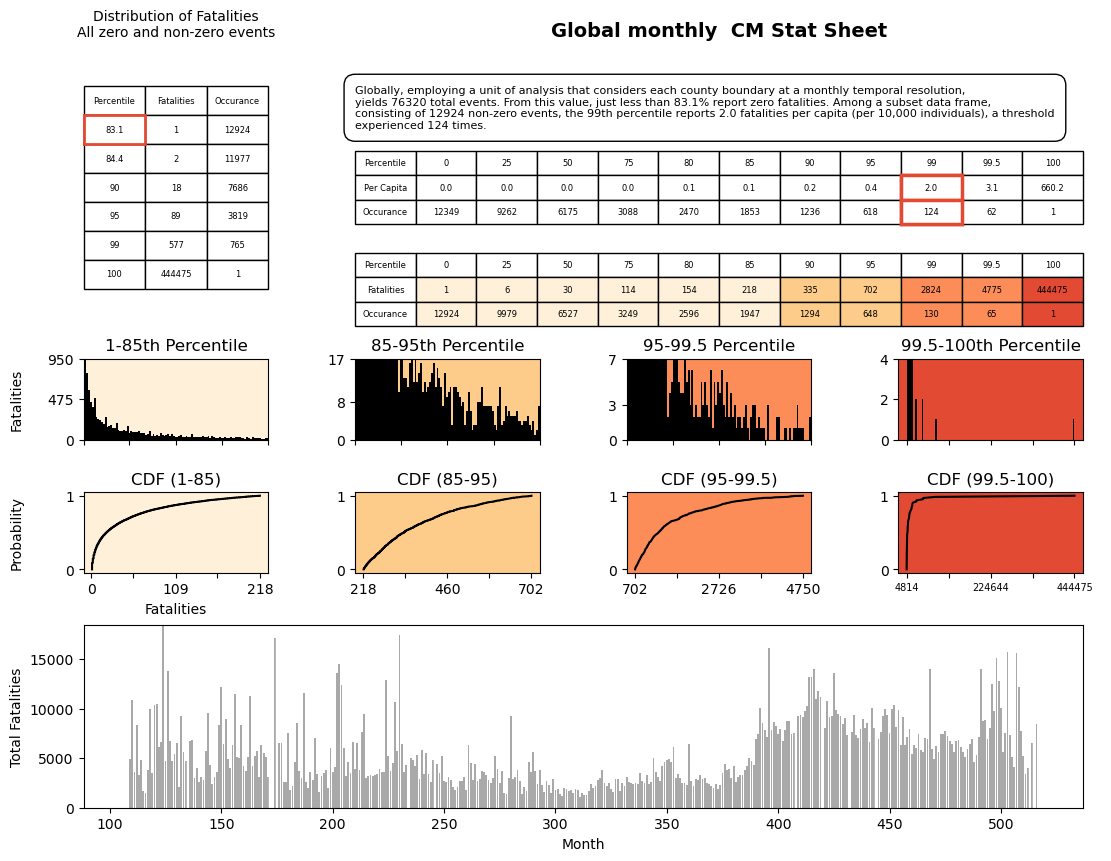

In [450]:
#countrylist = ['Syria', 'South Sudan', 'Yemen', 'Ethiopia', 'Nigeria', 'Rwanda', 'Senegal']

#for i in countrylist:
Pantaleon('CM', 'monthly', 0)


In [348]:
print(tx)

In Rwanda, employing a unit of analysis that considers a 3x3 priogrid at a monthly temporal resolution, yields 1224 total events. From this value, just less than 72.4% report zero fatalities. Among a subset data frame, consisting of 339 non-zero events, the 99th percentile reports 265.6 fatalities per capita (per 10,000 individuals), a threshold that has occurred 4 times.
